# Spirals
By Tanay Trivedi

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.random import randn

import tqdm

# Data Generation

In [2]:
NUM_ITERATIONS = 400
NUM_SPIRALS = 2
gamma=0.001

In [3]:
X = []
Y = []
res = 500
for spiral in range(NUM_SPIRALS):
    r=np.linspace(0.5,6,res)
    t=np.linspace(spiral*4, (spiral+4)*3.5,res)+ 0.2*randn(1,res);
    X.append([r*np.sin(t),r*np.cos(t)])
    Y.append((spiral)*np.ones((res,1)))
X = np.squeeze(X)
Y = np.squeeze(Y)

In [4]:
batch_size=10
factor=res*2/batch_size

In [5]:
x_sample = np.concatenate((X[0].T,X[1].T))
y_sample = np.concatenate((Y[0].T,Y[1].T))

In [6]:
from sklearn.utils import shuffle

In [7]:
x_sample,y_sample=shuffle(x_sample,y_sample,random_state=0)

In [8]:
y_sample1=np.stack((y_sample,1-y_sample)).T

In [9]:
def get_batch():
    return np.split(x_sample,factor),np.split(y_sample1,factor)

In [10]:
x_samp,y_samp=get_batch()

# Tensorflow

In [11]:
learning_rate = 0.001

In [12]:
n_hidden_1 = 20 # 1st layer number of neurons
n_hidden_2 = 20 # 2nd layer number of neurons
n_hidden_3 = 20 # 3rd layer number of neurons
n_input = 2 
n_classes = 2

In [13]:
tf_X = tf.placeholder(tf.float32, [batch_size,n_input])
tf_Y = tf.placeholder(tf.float32, [batch_size, n_classes])

In [14]:
weights = {
    'w1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'w2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'w3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_hidden_3, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [15]:
def multilayer_perceptron(x):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['w1']), biases['b1'])) #add relu
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])) #relu
    layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])) #relu
    out_layer = tf.nn.softmax(tf.matmul(layer_3, weights['out']) + biases['out']) # softmax
    return out_layer

In [16]:
logits = multilayer_perceptron(tf_X)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=tf_Y))
vs=tf.trainable_variables()
loss_op += tf.add_n([ tf.nn.l2_loss(v) for v in vs  ]) * gamma
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
init = tf.global_variables_initializer()

In [17]:
batch_index=np.arange(factor)

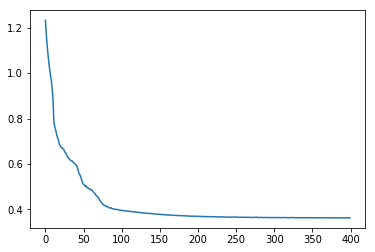

In [18]:
sess=tf.Session() 
sess.run(init)
losses=[]
for it in range(NUM_ITERATIONS):
    #randomly order 0-49. run through that order below
    np.random.shuffle(batch_index)
    avgCost = 0
    for i in batch_index.astype(int):
        _,loss_1=sess.run([train_op,loss_op],feed_dict = {tf_X:x_samp[i],tf_Y:y_samp[i]})
        avgCost+=loss_1
    losses.append(avgCost/(factor))
plt.plot(losses)

In [19]:
x_sample = np.concatenate((X[0].T,X[1].T))
y_sample = np.concatenate((Y[0].T,Y[1].T))
x_sample,y_sample=shuffle(x_sample,y_sample,random_state=0)
x_samp=np.split(x_sample,res*2/batch_size)
yhat=[]
for i in x_samp:
    yhat.append(sess.run(logits,feed_dict = {tf_X:i}))

In [20]:
yhat=np.array(yhat)

In [21]:
yhat=np.concatenate(yhat)

In [22]:
proba=np.squeeze(yhat>0.5)

In [23]:
accuracy = np.sum(np.equal(proba[:,0], y_sample==1)) * 100 / 1000

In [24]:
accuracy

100.0

In [25]:
domain = np.arange(-6, 6, 0.1)
xCont, yCont = np.meshgrid(domain, domain)

In [26]:
xflat=xCont.flatten()
yflat=yCont.flatten()
together=np.stack((xflat,yflat),axis=1)

In [27]:
together_batches=np.split(together,len(together)/batch_size)

In [28]:
def infer_probability(x):
    return sess.run(logits, feed_dict={tf_X: x})[:,1]

In [29]:
z =[]
for i in together_batches:
    z.append(infer_probability(i))

In [30]:
z=np.array(z)
z=np.concatenate(z)

In [31]:
z=np.reshape(z,(120,120))

In [32]:
plot_x=x_sample[:,0]
plot_y=x_sample[:,1]

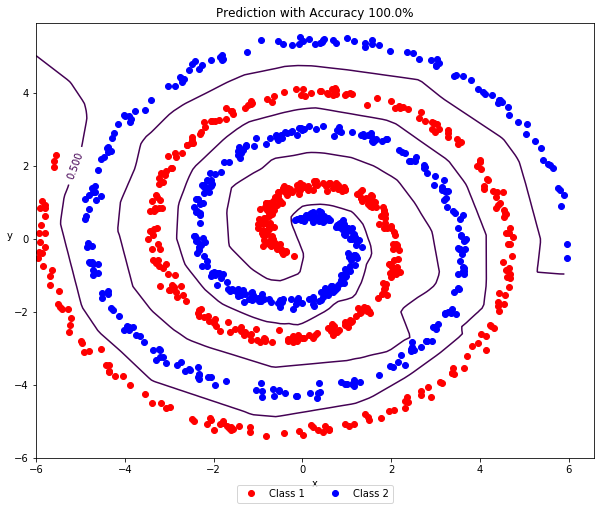

In [33]:
plt.figure(figsize=[10,8])
bound = plt.contour(xCont, yCont, z, levels=[0.5])
plt.clabel(bound, inline=1, fontsize=10)

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Prediction with Accuracy {}%'.format(accuracy))
plt.plot(plot_x[proba[:,0] == True], plot_y[proba[:,0] == True], 'ro', label='Class 1')
plt.plot(plot_x[proba[:,0] == False], plot_y[proba[:,0] == False], 'bo', label='Class 2')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.show()

# Discussion

I attempted several different kinds of neural architectures to achieve this performance. At first I had the minimum number of layers to achieve a higher linear basis, 2. Starting with 5 neurons in each, I increased until around 20. Sometimes I achieved high accuracies, sometimes I didn't. I then went up another set of basis by having 3 layers, this achieved 100% accuracy more consistently. My final architecture is 3 layers by 20 neurons.